### Step 1: Importing the Relevant Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection  import cross_val_score
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

### Step 2: Data Inspection

In [2]:
df = pd.read_csv("MegaStore.csv")

In [3]:
df.shape

(8523, 12)

__MegaStore has 8523 rows and 12 columns__

In [4]:
#ratio of null values
df.isnull().sum()/df.shape[0] *100

Item                        0.000000
Itemtype                    0.000000
Weight                     17.165317
FatContent                  0.000000
Visibility                  0.000000
MRP                         0.000000
Outlet                      0.000000
OutletEstablishmentYear     0.000000
OutletSize                 28.276428
OutletCity                  0.000000
OutletType                  0.000000
Sales                       0.000000
dtype: float64

In [5]:
#categorical features
categorical = df.select_dtypes(include =[np.object])
print("Categorical Features:",categorical.shape[1])

#numerical features
numerical= df.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features:",numerical.shape[1])

Categorical Features: 7
Numerical Features: 5


__Weight__

<AxesSubplot:xlabel='Weight'>

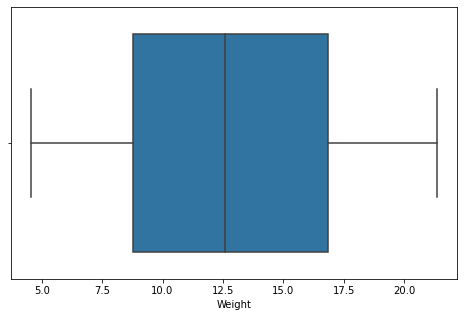

In [6]:
plt.figure(figsize=(8,5))
sns.boxplot('Weight',data=df)

__The Box Plots above clearly show no "Outliers" and hence we can impute the missing values with "Mean"__

In [7]:
df['Weight']= df['Weight'].fillna(df['Weight'].mean())

In [8]:
df['Weight'].isnull().sum()

0

__Outlet Size__

In [9]:
df['OutletSize'].isnull().sum()

2410

In [10]:
print(df['OutletSize'].value_counts())

Medium    2793
Small     2388
High       932
Name: OutletSize, dtype: int64


__Since the outlet_size is a categorical column, we can impute the missing values by "Mode"__

__Let us see its association with OutletType column__

In [11]:
mode_of_outletSize=df.pivot_table(values='OutletSize', columns='OutletType', aggfunc=(lambda x:x.mode()[0]))
print(mode_of_outletSize)

OutletType Grocery Store Supermarket Type1 Supermarket Type2 Supermarket Type3
OutletSize         Small             Small            Medium            Medium


In [12]:
missing_value=df['OutletSize'].isnull()
missing_value

0        True
1       False
2       False
3       False
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: OutletSize, Length: 8523, dtype: bool

In [13]:
df.loc[missing_value,'OutletSize']=df.loc[missing_value,'OutletType'].apply(lambda x: mode_of_outletSize[x])

In [14]:
df['OutletSize'].isnull().sum()

0

In [15]:
df.describe()

,Weight,Visibility,MRP,OutletEstablishmentYear,Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [16]:
df.columns

Index(['Item', 'Itemtype', 'Weight', 'FatContent', 'Visibility', 'MRP',
       'Outlet', 'OutletEstablishmentYear', 'OutletSize', 'OutletCity',
       'OutletType', 'Sales'],
      dtype='object')

In [17]:
df['FatContent'].value_counts()

Low Fat    5089
Regular    2889
Low         316
reg         117
low fat     112
Name: FatContent, dtype: int64

__Let us fix these irregularities.__

In [18]:
df['FatContent'].replace(['low fat','Low','reg'],['Low Fat','Low Fat','Regular'],inplace = True)

In [19]:
df['FatContent']= df['FatContent'].astype(str)

__Determine the years of operation of a store__

In [20]:
df['OutletYears'] = 2021 - df['OutletEstablishmentYear']

__Create a broad category of Type of Item__

In [21]:
df['ItemTypeCombined'] = df['Item'].apply(lambda x: x[0:2])
df['ItemTypeCombined'] = df['ItemTypeCombined'].map({'FD':'Food','NC':'Non-Consumable','DR':'Drinks'})

__Modify categories of Item_Fat_Content__

In [22]:
#Mark non-consumables as separate category in low_fat:
df.loc[df['ItemTypeCombined']=="Non-Consumable",'FatContent'] = "Non-Edible"
df['FatContent'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: FatContent, dtype: int64

__Check for presence of Outliers__

<function matplotlib.pyplot.show(close=None, block=None)>

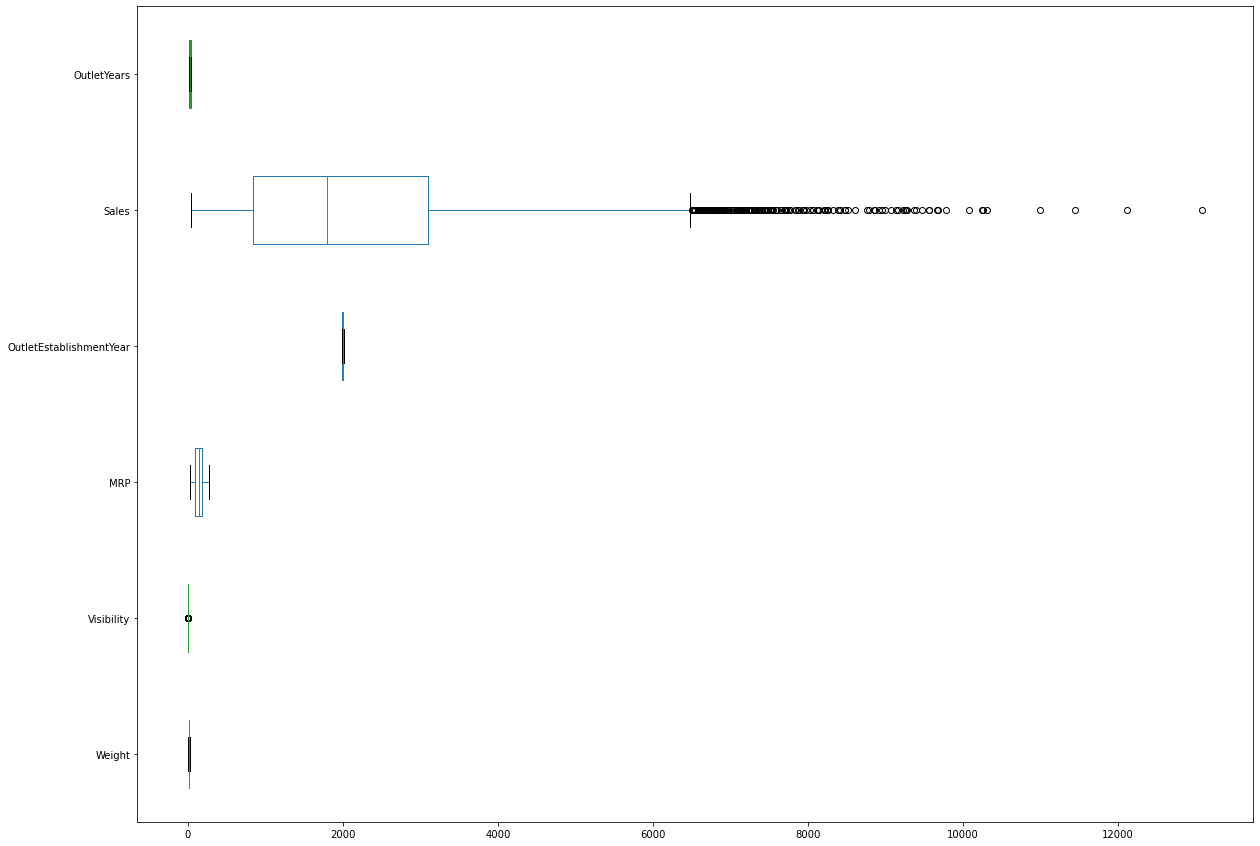

<Figure size 37440x14400 with 0 Axes>

In [23]:
df.plot(kind='box',vert=False,figsize = (20,15))
plt.figure(figsize=(520,200))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

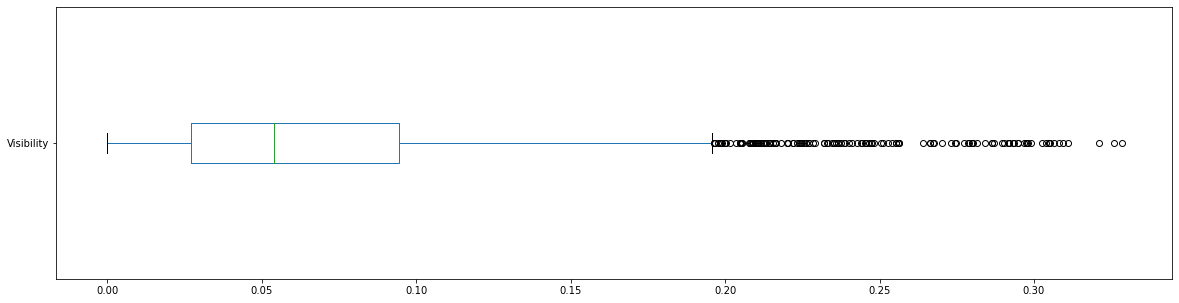

<Figure size 1440x360 with 0 Axes>

In [24]:
df.Visibility.plot(kind='box',vert=False,figsize = (20,5))
plt.figure(figsize=(20,5))
plt.show

__Treating the outliers in Visibility with maximum__

In [25]:
Q1=df.Visibility.quantile(0.25)
Q3=df.Visibility.quantile(0.75)
IQR=Q3-Q1
Upper_Whisker = Q3+1.5*IQR

<AxesSubplot:>

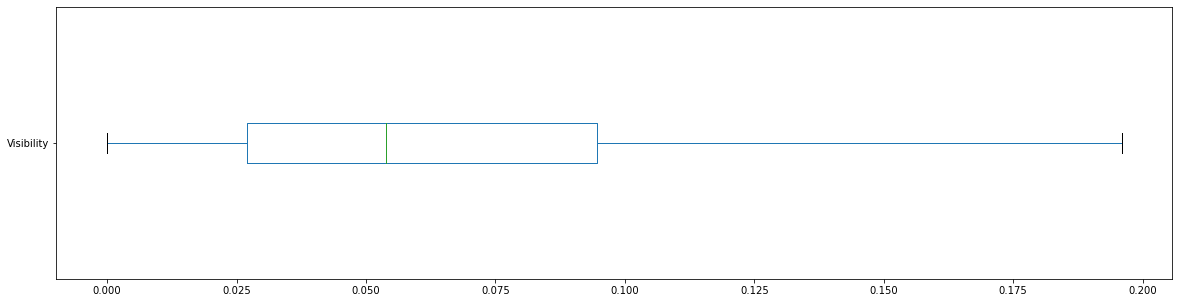

In [26]:
df["Visibility"] = df["Visibility"].mask(df["Visibility"] >Upper_Whisker, Upper_Whisker)
df.Visibility.plot(kind='box',vert=False,figsize = (20,5))

<AxesSubplot:xlabel='FatContent', ylabel='count'>

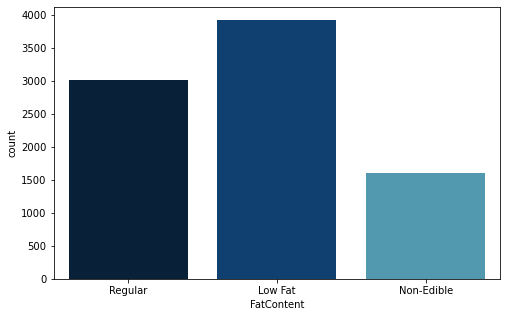

In [28]:
plt.figure(figsize=(8,5))
sns.countplot('FatContent',data=df,palette='ocean')

__The Items bought are more of Low Fat.__

<AxesSubplot:xlabel='Itemtype', ylabel='count'>

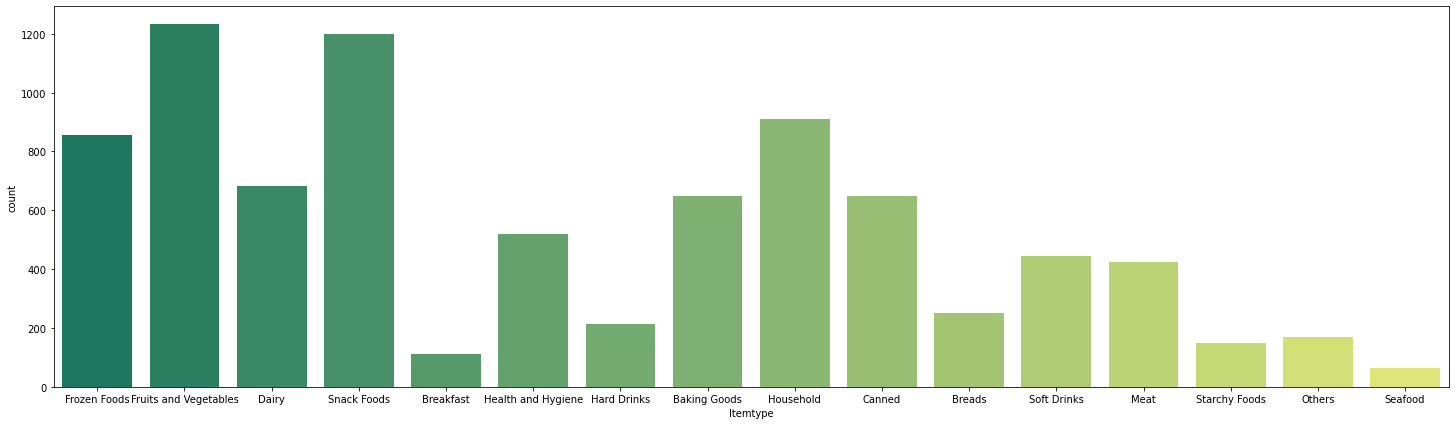

In [29]:
plt.figure(figsize=(25,7))
sns.countplot('Itemtype',data=df,palette='summer')

__Fruits and Vegetables are largely sold as people tend to use them on daily purpose__ <br>
__Snack Food are also sold a lot__ <br>
__Seafood are sold the least__

<AxesSubplot:xlabel='OutletSize', ylabel='count'>

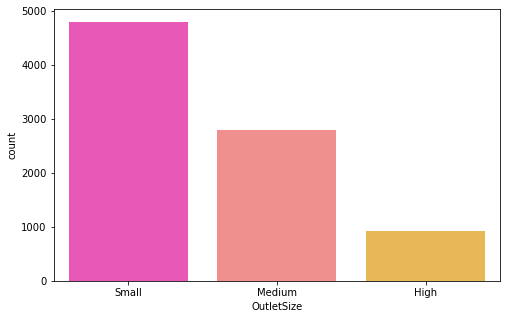

In [30]:
plt.figure(figsize=(8,5))
sns.countplot('OutletSize',data=df,palette='spring')

* __The Outlets are more of Small Size__

<AxesSubplot:xlabel='OutletCity', ylabel='count'>

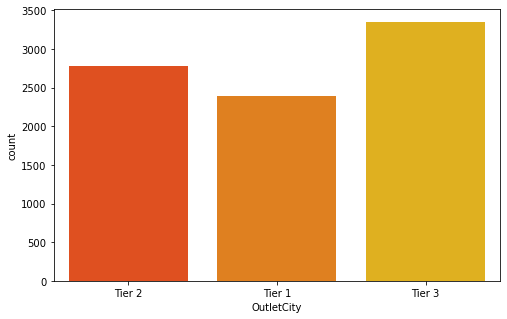

In [31]:
plt.figure(figsize=(8,5))
sns.countplot('OutletCity',data=df,palette='autumn')

__The Outlets are maximum in number in Tier 3 Cities__

<AxesSubplot:xlabel='OutletType', ylabel='count'>

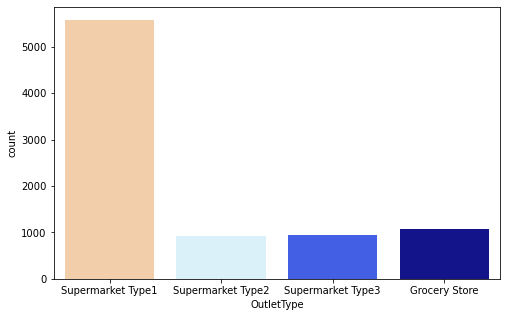

In [32]:
plt.figure(figsize=(8,5))
sns.countplot('OutletType',data=df,palette='flag')

__The Outlets are more of Supermarket Type1__

<AxesSubplot:xlabel='Sales', ylabel='Itemtype'>

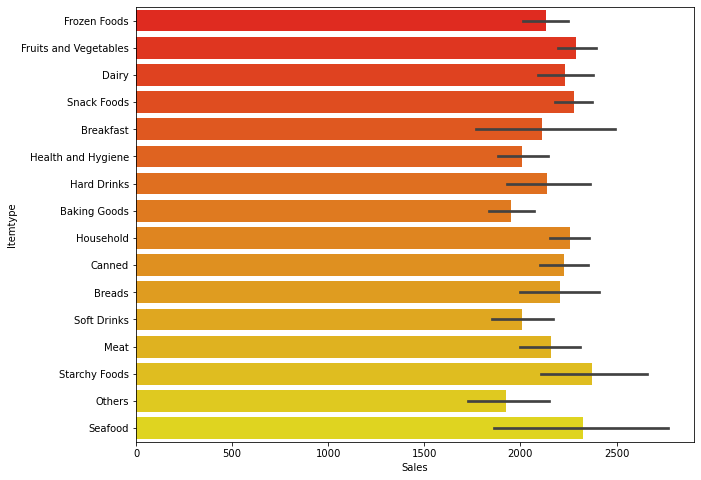

In [33]:
plt.figure(figsize=(10,8))
sns.barplot(y='Itemtype',x='Sales',data=df,palette='autumn')

__The products available were Fruits-Veggies and Snack Foods but the sales of Seafood and Starchy Foods seems higher__

__The sales can be improved with having stock of products that are most bought by customers.__

In [34]:
df.columns

Index(['Item', 'Itemtype', 'Weight', 'FatContent', 'Visibility', 'MRP',
       'Outlet', 'OutletEstablishmentYear', 'OutletSize', 'OutletCity',
       'OutletType', 'Sales', 'OutletYears', 'ItemTypeCombined'],
      dtype='object')

Text(0, 0.5, 'Item Visibility')

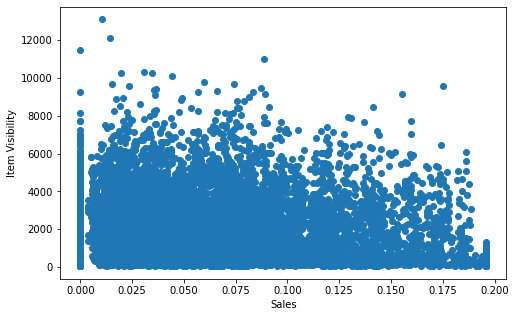

In [35]:
plt.figure(figsize=(8,5))
plt.scatter('Visibility','Sales',data=df)
plt.xlabel('Sales')
plt.ylabel('Item Visibility')

__Item_Visibility has a minimum value of zero. <br>
This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0. <br> <br>
Lets consider it like missing information and impute it with mean visibility of that product.__

In [36]:
df['Visibility']=df['Visibility'].replace(0,df['Visibility'].mean())

Text(0, 0.5, 'Item Visibility')

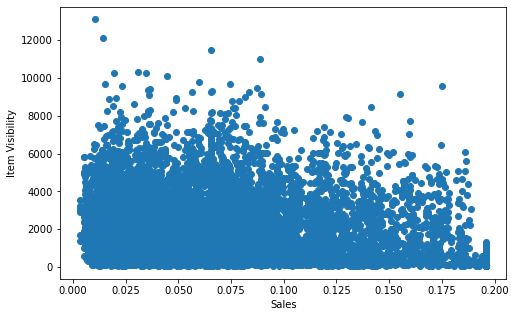

In [37]:
plt.figure(figsize=(8,5))
plt.scatter('Visibility','Sales',data=df)
plt.xlabel('Sales')
plt.ylabel('Item Visibility')

__We can see that now visibility is not exactly zero and it has some value indicating that Item is rarely purchased by the customers.__

Text(0, 0.5, 'Sales')

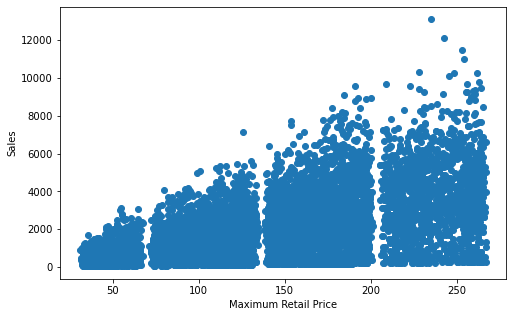

In [38]:
plt.figure(figsize=(8,5))
plt.scatter(y='Sales',x='MRP',data=df)
plt.xlabel('Maximum Retail Price')
plt.ylabel('Sales')

__Items with MRP ranging from 200-250 dollars is having high Sales__

<AxesSubplot:xlabel='OutletCity', ylabel='Sales'>

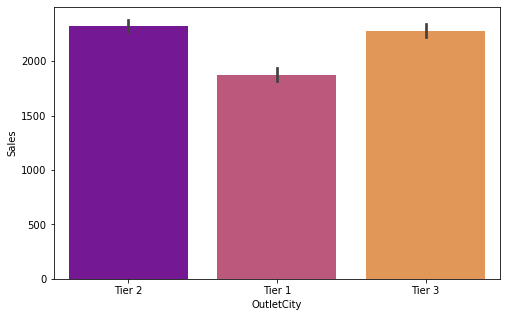

In [39]:
plt.figure(figsize=(8,5))
sns.barplot(x='OutletCity',y='Sales',data=df,palette='plasma')

__The Outlet Sales tend to be high for Tier3 and Tier 2 location types but we have only Tier3 locations maximum Outlets.__

<AxesSubplot:xlabel='OutletYears', ylabel='Sales'>

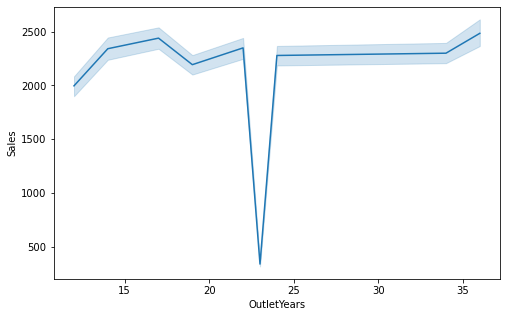

In [40]:
plt.figure(figsize=(8,5))
sns.lineplot(x='OutletYears',y='Sales',data=df,palette='viridis')

__It is quiet evident that Outlets established 35 years before is having good Sales margin. <br>
We also have a outlet which was established before 22 years has the lowest sales margin, so established years wouldn't improve the Sales unless the products are sold according to customer's interest.<br>
Let us check the Vif for all features__

In [41]:
df.columns

Index(['Item', 'Itemtype', 'Weight', 'FatContent', 'Visibility', 'MRP',
       'Outlet', 'OutletEstablishmentYear', 'OutletSize', 'OutletCity',
       'OutletType', 'Sales', 'OutletYears', 'ItemTypeCombined'],
      dtype='object')

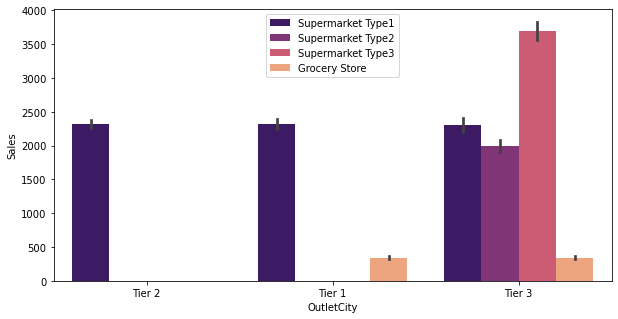

In [42]:
plt.figure(figsize=(10,5))
sns.barplot('OutletCity','Sales',hue='OutletType',data=df,palette='magma')
plt.legend()

__The Tier-3 location type has all types of Outlet type and has high sales margin.__

__Numerical and One-Hot Coding of Categorical variables__

In [43]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_mod = ['Item','FatContent','Itemtype','Outlet','OutletCity','OutletSize','ItemTypeCombined','OutletType']
for i in var_mod:
    df[i] = le.fit_transform(df[i])

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=pd.Series([variance_inflation_factor(df.values,idx)
              for idx in range(df.shape[1])],
             index=df.columns)
print(vif)

Item                        2.642183
Itemtype                    1.009037
Weight                      1.005955
FatContent                  1.044218
Visibility                  1.061704
MRP                         1.653508
Outlet                      4.163347
OutletEstablishmentYear    80.951112
OutletSize                  1.705836
OutletCity                  5.457539
OutletType                  2.967184
Sales                       2.013811
OutletYears                10.726077
ItemTypeCombined            2.669085
dtype: float64


In [45]:
df.drop('OutletEstablishmentYear',axis=1, inplace=True)

In [46]:
vif=pd.Series([variance_inflation_factor(df.values,idx)
              for idx in range(df.shape[1])],
             index=df.columns)
print(vif)

Item                10.597912
Itemtype             3.853230
Weight               9.250446
FatContent           2.069287
Visibility           3.402869
MRP                  9.629610
Outlet              11.117923
OutletSize           6.582504
OutletCity          10.177923
OutletType           9.403796
Sales                5.276298
OutletYears          7.956001
ItemTypeCombined    14.249072
dtype: float64


In [47]:
df.drop('ItemTypeCombined',axis=1, inplace=True)
vif=pd.Series([variance_inflation_factor(df.values,idx)
              for idx in range(df.shape[1])],
             index=df.columns)
print(vif)

Item            4.048615
Itemtype        3.841293
Weight          9.190636
FatContent      2.049684
Visibility      3.400598
MRP             9.597402
Outlet         11.072736
OutletSize      6.552192
OutletCity     10.116194
OutletType      9.400809
Sales           5.274079
OutletYears     7.923116
dtype: float64


In [48]:
df.drop('Outlet',axis=1, inplace=True)
vif=pd.Series([variance_inflation_factor(df.values,idx)
              for idx in range(df.shape[1])],
             index=df.columns)
print(vif)

Item           4.012390
Itemtype       3.780569
Weight         8.765017
FatContent     2.043256
Visibility     3.393886
MRP            9.483509
OutletSize     5.432268
OutletCity     4.045292
OutletType     5.441747
Sales          5.269497
OutletYears    7.415483
dtype: float64


<AxesSubplot:>

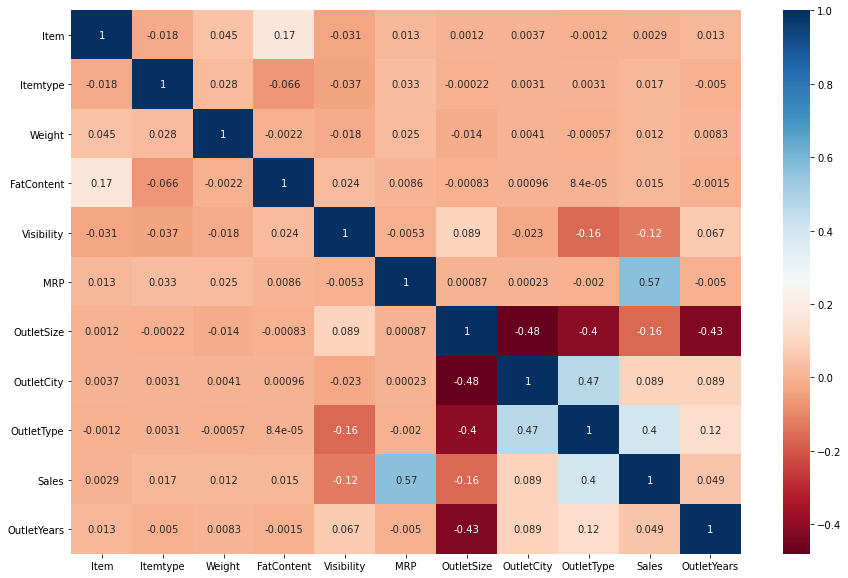

In [49]:
plt.figure (figsize=(15,10))
sns.heatmap(df.corr(),cmap='RdBu', annot=True)

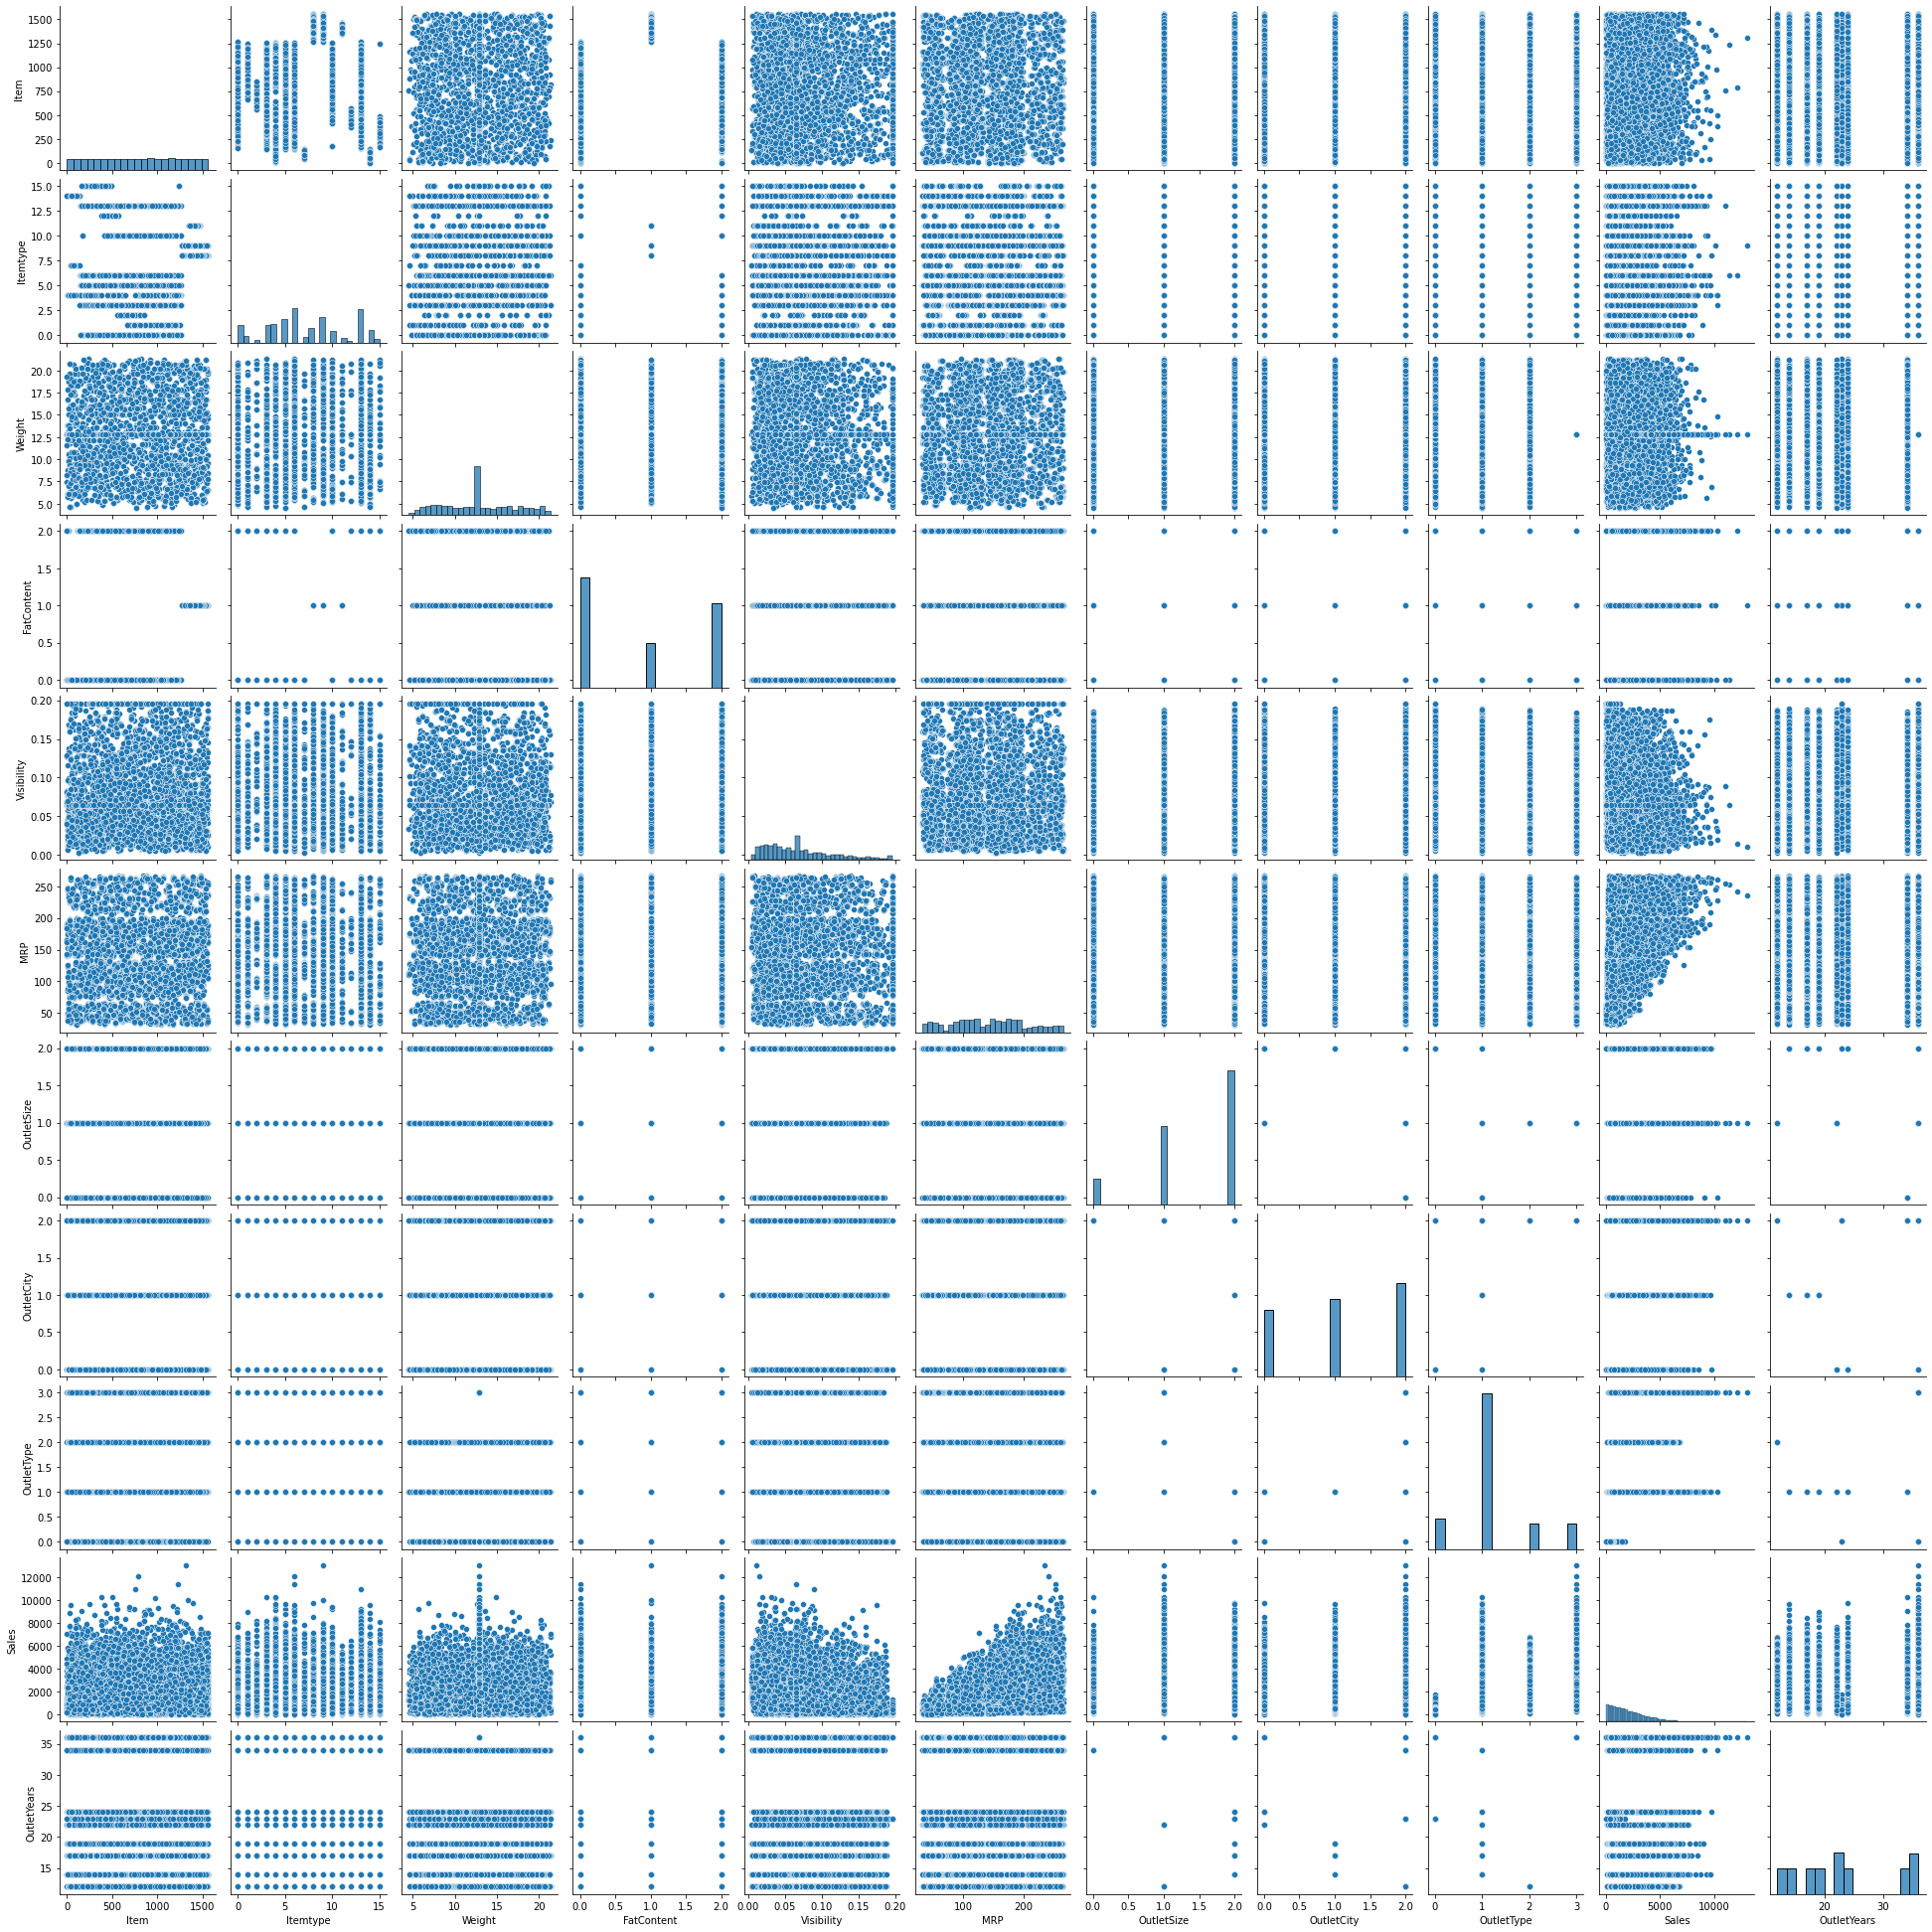

In [50]:
sns.pairplot(df)

__As most of them are categorical column, we need to go for other statistical tests__

In [51]:
df.columns

Index(['Item', 'Itemtype', 'Weight', 'FatContent', 'Visibility', 'MRP',
       'OutletSize', 'OutletCity', 'OutletType', 'Sales', 'OutletYears'],
      dtype='object')

In [52]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [54]:
for col in df.drop(columns=['Item','Weight','MRP','Visibility','Sales']).columns:
    stats_model=smf.ols('Sales ~ ' + col, data=df).fit()
    print(sm.stats.anova_lm(stats_model,type=2))

              df        sum_sq       mean_sq         F    PR(>F)
Itemtype     1.0  7.212469e+06  7.212469e+06  2.477119  0.115551
Residual  8521.0  2.481005e+10  2.911636e+06       NaN       NaN
                df        sum_sq       mean_sq         F    PR(>F)
FatContent     1.0  5.771058e+06  5.771058e+06  1.981952  0.159221
Residual    8521.0  2.481149e+10  2.911805e+06       NaN       NaN
                df        sum_sq       mean_sq           F        PR(>F)
OutletSize     1.0  6.573761e+08  6.573761e+08  231.851299  1.122518e-51
Residual    8521.0  2.415989e+10  2.835335e+06         NaN           NaN
                df        sum_sq       mean_sq          F        PR(>F)
OutletCity     1.0  1.982010e+08  1.982010e+08  68.600115  1.389024e-16
Residual    8521.0  2.461906e+10  2.889222e+06        NaN           NaN
                df        sum_sq       mean_sq            F  PR(>F)
OutletType     1.0  4.001047e+09  4.001047e+09  1637.805921     0.0
Residual    8521.0  2.081622e+10 

__We can see ['FatContent','Itemtype'] have little/ no effect on the sales__

In [55]:
df.drop(columns = ['FatContent','Itemtype'], axis=1, inplace=True)

In [56]:
df = df.select_dtypes(exclude='object')

In [57]:
df.columns

Index(['Item', 'Weight', 'Visibility', 'MRP', 'OutletSize', 'OutletCity',
       'OutletType', 'Sales', 'OutletYears'],
      dtype='object')

In [58]:
#One Hot Coding:
df = pd.get_dummies(df, columns=['OutletCity','OutletSize','OutletType'])

In [59]:
X= df.drop(columns = ['Sales'], axis=1)
y= df['Sales']

In [60]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=1)

In [61]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
x_train_minmax=mm_scaler.fit_transform(X_train)

In [62]:
X_train=pd.DataFrame(x_train_minmax, columns=X.columns)

In [63]:
x_test_minmax=mm_scaler.transform(X_valid)

In [64]:
X_valid=pd.DataFrame(x_test_minmax, columns=X.columns)

<AxesSubplot:xlabel='Sales', ylabel='Density'>

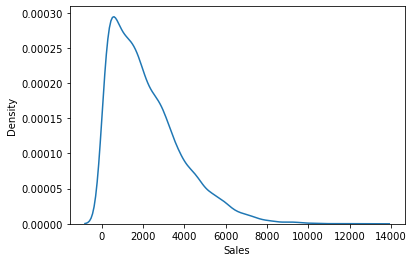

In [66]:
sns.kdeplot(df.Sales)

<AxesSubplot:xlabel='Sales', ylabel='Density'>

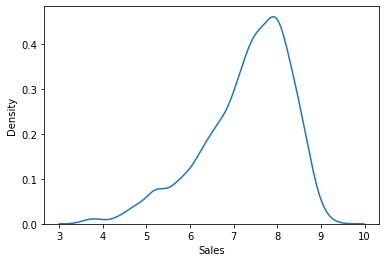

In [65]:
sns.kdeplot(np.log(df.Sales))

__let us also transform our target__

In [67]:
y_train,y_valid = np.log(y_train),np.log(y_valid)

### Step 3: Building Model

# Linear Regression

In [68]:
df.columns

Index(['Item', 'Weight', 'Visibility', 'MRP', 'Sales', 'OutletYears',
       'OutletCity_0', 'OutletCity_1', 'OutletCity_2', 'OutletSize_0',
       'OutletSize_1', 'OutletSize_2', 'OutletType_0', 'OutletType_1',
       'OutletType_2', 'OutletType_3'],
      dtype='object')

In [69]:
LRmodel = LinearRegression(normalize=True)
LRmodel.fit(X_train,y_train)
y_pred = LRmodel.predict(X_valid)
print("Train Accuracy:",LRmodel.score(X_train,y_train))
print("Test Accuracy:",LRmodel.score(X_valid,y_valid))

Train Accuracy: 0.7177792139434944
Test Accuracy: 0.7280598843795556


In [70]:
MSE= metrics.mean_squared_error(y_valid,y_pred)
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

Root Mean Squared Error: 0.5487557399922945


In [71]:
MSE= metrics.mean_squared_error(np.exp(y_valid),np.exp(y_pred))
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

Root Mean Squared Error: 1154.6156327340898


# Polynomial Regression

In [72]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train)
training_data_prediction = lin_reg2.predict(X_poly)
print("Train Accuracy:",metrics.r2_score(y_train, training_data_prediction))
X_poly_test = poly.fit_transform(X_valid)
testing_data_prediction = lin_reg2.predict(X_poly_test)
print("Test Accuracy:",metrics.r2_score(y_valid, testing_data_prediction))
MSE= metrics.mean_squared_error(y_valid,testing_data_prediction)
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

Train Accuracy: 0.7380108908706184
Test Accuracy: 0.7518227104165673
Root Mean Squared Error: 0.5242319133117949


In [73]:
#With degree as 3
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
lin_reg3 = LinearRegression()
lin_reg3.fit(X_poly,y_train)
training_data_prediction = lin_reg3.predict(X_poly)
print("Train Accuracy:",metrics.r2_score(y_train, training_data_prediction))
X_poly_test = poly.fit_transform(X_valid)
testing_data_prediction = lin_reg3.predict(X_poly_test)
print("Test Accuracy:",metrics.r2_score(y_valid, testing_data_prediction))
MSE= metrics.mean_squared_error(y_valid,testing_data_prediction)
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

Train Accuracy: 0.7389795570298674
Test Accuracy: 0.7416798170195875
Root Mean Squared Error: 0.5348372004736934


In [74]:
#With degree as 4
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X_train)
lin_reg4 = LinearRegression()
lin_reg4.fit(X_poly,y_train)
training_data_prediction = lin_reg4.predict(X_poly)
print("Train Accuracy:",metrics.r2_score(y_train, training_data_prediction))
X_poly_test = poly.fit_transform(X_valid)
testing_data_prediction = lin_reg4.predict(X_poly_test)
print("Test Accuracy:",metrics.r2_score(y_valid, testing_data_prediction))
MSE= metrics.mean_squared_error(y_valid,testing_data_prediction)
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

Train Accuracy: 0.7487770023091874
Test Accuracy: 0.7353176876143311
Root Mean Squared Error: 0.5413833525570321


## Using decision tree regressor

In [75]:
dtregressor = DecisionTreeRegressor(random_state = 22)
dtregressor.fit(X_train,y_train)
print("Train Accuracy:",dtregressor.score(X_train,y_train))
print("Test Accuracy:",dtregressor.score(X_valid,y_valid))

Train Accuracy: 1.0
Test Accuracy: 0.46733121452842896


In [76]:
y_pred=dtregressor.predict(X_valid)
MSE= metrics.mean_squared_error(y_valid,y_pred)
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

Root Mean Squared Error: 0.7680174027332689


# Using XGB regressor

In [77]:
xgbregressor = XGBRegressor()
xgbregressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
training_data_prediction = xgbregressor.predict(X_train)
print("Train Accuracy:",metrics.r2_score(y_train, training_data_prediction))
test_data_prediction = xgbregressor.predict(X_valid)
print("Test Accuracy:",metrics.r2_score(y_valid, test_data_prediction))
MSE= metrics.mean_squared_error(y_valid,test_data_prediction)
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

Train Accuracy: 0.8912189635409615
Test Accuracy: 0.7095071674281372
Root Mean Squared Error: 0.5671659471395971


# Random Forest Regressor

In [79]:
rfregressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
rfregressor.fit(X_train, y_train)
training_data_prediction = rfregressor.predict(X_train)
print("Train Accuracy:",metrics.r2_score(y_train, training_data_prediction))
test_data_prediction = rfregressor.predict(X_valid)
print("Test Accuracy:",metrics.r2_score(y_valid, test_data_prediction))
MSE= metrics.mean_squared_error(y_valid,test_data_prediction)
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

Train Accuracy: 0.9582190017782729
Test Accuracy: 0.7086135449334056
Root Mean Squared Error: 0.5680376434556185


# AdaBoostRegressor

In [80]:
X, y = make_regression(n_features=4, n_informative=10,random_state=0, shuffle=False)
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train, y_train)
training_data_prediction = regr.predict(X_train)
print("Train Accuracy:",metrics.r2_score(y_train, training_data_prediction))
test_data_prediction = regr.predict(X_valid)
print("Test Accuracy:",metrics.r2_score(y_valid, test_data_prediction))
MSE= metrics.mean_squared_error(y_valid,test_data_prediction)
rmse = sqrt(MSE)
print("Root Mean Squared Error:",rmse)

Train Accuracy: 0.6743631195557593
Test Accuracy: 0.6874350651604132
Root Mean Squared Error: 0.5883185803825416


# Cross Validation

In [81]:
def cross_val(model_name,model,X,y,cv):
    scores = cross_val_score(model, X, y, cv=cv)
    print(f'{model_name} Scores:')
    for i in scores:
        print(round(i,2))
    print(f'Average {model_name} score: {round(scores.mean(),2)}')

In [82]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, random_state=1, shuffle=True)
cross_val(LRmodel,LinearRegression(),X,y,cv)

LinearRegression(normalize=True) Scores:
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Average LinearRegression(normalize=True) score: 1.0


In [83]:
poly = PolynomialFeatures(degree=2)
cross_val(lin_reg2,LinearRegression(),poly.fit_transform(X),y,cv)

LinearRegression() Scores:
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Average LinearRegression() score: 1.0


In [84]:
cross_val(dtregressor,DecisionTreeRegressor(random_state = 22),X,y,cv)

DecisionTreeRegressor(random_state=22) Scores:
0.51
0.59
0.82
0.69
0.85
0.9
0.59
0.6
0.58
0.51
Average DecisionTreeRegressor(random_state=22) score: 0.66


In [85]:
cross_val(xgbregressor,XGBRegressor(),X,y,cv)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) Scores:
0.75
0.83
0.96
0.77
0.86
0.92
0.8
0.88
0.92
0.67
Average XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
           

In [86]:
cross_val(rfregressor,RandomForestRegressor(n_estimators = 100, random_state = 0),X,y,10)

RandomForestRegressor(random_state=0) Scores:
0.72
0.79
0.81
0.9
0.91
0.92
0.77
0.93
0.81
0.84
Average RandomForestRegressor(random_state=0) score: 0.84


In [87]:
cross_val(regr,AdaBoostRegressor(random_state=0, n_estimators=100),X,y,10)

AdaBoostRegressor(n_estimators=100, random_state=0) Scores:
0.59
0.85
0.87
0.83
0.9
0.84
0.58
0.9
0.71
0.8
Average AdaBoostRegressor(n_estimators=100, random_state=0) score: 0.79


__Cross Validation on XGBRegressor and Random Forest Regressor yeilds a score of 0.84__